<a href="https://colab.research.google.com/github/Salimdebit/proportionseniors/blob/main/pr_diction_proportions_75_ans_1590.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objectif
Prédire la proportion de seniors de 75 ans ou plus gagnant plus de 1590 euros  par mois (seuil ajustable et tranche d'âge ajustables) au niveau de l'IRIS, en se basant sur des données de logement. Pour cela, on choisit de développer un modèle de régression capable d'estimer directement cette proportion.



#Préparation des caractéristiques: aggrégation de données de logement à la commune


Dans cette première étape, on prépare les variables explicatives du modèles, les données de logement, qui serviront à l'entraînement du modèle de régression. Les données de logement initialement disponibles au niveau de l'IRIS sont agrégées à l'échelle communale pour être cohérentes avec les données cibles.

**Objectif: disposer d'un ensemble de variables explicatives au niveau communal pour entraîner le modèle de régression dont les cibles sont au niveau communal**


In [ ]:
import pandas as pd
import numpy as np

# Charger les données de logements
housing_iris = pd.read_csv('base-ic-logement-2020.CSV', sep=';', dtype={'IRIS': str})

# Charger le fichier liant les IRIS aux communes
iris_commune = pd.read_excel(
    'reference_IRIS_geo2022.xlsx',
    sheet_name='Emboitements_IRIS',
    header=5,  # Les noms des colonnes sont à la ligne 6 (index 5)
    dtype=str
)

# Afficher les colonnes pour vérification
print("Colonnes de iris_commune :", iris_commune.columns.tolist())

# Renommer les colonnes pour permettre l'association
iris_commune.rename(columns={
    'IRIS': 'CODE_IRIS',
    'COM': 'DEPCOM'
}, inplace=True)

# Vérifier la présence des colonnes essentielles
assert 'CODE_IRIS' in iris_commune.columns, "La colonne 'CODE_IRIS' est manquante dans iris_commune"
assert 'DEPCOM' in iris_commune.columns, "La colonne 'DEPCOM' est manquante dans iris_commune"

# Renommer la colonne 'IRIS' en 'CODE_IRIS' dans housing_iris
housing_iris.rename(columns={'IRIS': 'CODE_IRIS'}, inplace=True)

# Fusionner les données de logements avec la référence IRIS-commune
housing_iris_commune = pd.merge(
    housing_iris,
    iris_commune[['CODE_IRIS', 'DEPCOM']],
    on='CODE_IRIS',
    how='left'
)

# Convertir toutes les colonnes numériques en numériques
# Exclure 'CODE_IRIS' et 'DEPCOM' lors de la conversion
numeric_cols = housing_iris_commune.columns.drop(['CODE_IRIS', 'DEPCOM'])
for col in numeric_cols:
    housing_iris_commune[col] = pd.to_numeric(housing_iris_commune[col], errors='coerce')

# Agréger les données au niveau communal en sommant les variables
housing_commune = housing_iris_commune.groupby('DEPCOM')[numeric_cols].sum().reset_index()

# Remplacer les valeurs infinies ou NaN résultant de divisions par zéro (si applicable)
housing_commune.replace([np.inf, -np.inf], np.nan, inplace=True)
housing_commune.fillna(0, inplace=True)

# Enregistrer les données agrégées au niveau communal AVEC toutes les variables
housing_commune.to_csv('housing_commune_aggregated_all_vars.csv', index=False)



FileNotFoundError: [Errno 2] No such file or directory: 'base-ic-logement-2020.CSV'

#Préparation des cibles : proportion des séniors à partir des données de revenus 2021 (disponibles pour 5000 communes)

Dans cette deuxième étape, on calcule la proportion de seniors de 75 ans ou plus gagnant plus de 1590 euros par mois pour environ 5000 communes disposant des données sur les déciles et quartiles.


Détails:

On utilise  les données de revenus 2021 de l'INSEE, qui fournissent la distribution des revenus par déciles pour la tranche d'âge concernée.
En exploitant les déciles de revenus, nous estime la proportion de seniors dépassant le seuil de 1590 euros par mois dans chaque commune. Ces proportions serviront de cibles pour notre modèle.

**Objectif:**
**Disposer des cibles pour entrainer le modèle**

In [ ]:
import pandas as pd
import numpy as np

# 1. Chargement des données de revenus

revenus_com = pd.read_csv('FILO2021_DISP_COM.csv', sep=';', decimal=',', dtype={'CODGEO': str})

# 2. Conversion des colonnes de quantiles en numérique

quantile_cols = [
    'AGE6D121', 'AGE6D221', 'AGE6D321', 'AGE6D421',
    'AGE6Q121', 'AGE6Q221', 'AGE6Q321',
    'AGE6D621', 'AGE6D721', 'AGE6D821', 'AGE6D921'
]

for col in quantile_cols:
    revenus_com[col] = pd.to_numeric(revenus_com[col], errors='coerce')

# 3. Elimination des communes avec des données de revenus manquants

revenus_com_filtered = revenus_com.dropna(subset=quantile_cols)

# 4. Mapping des colonnes de quantiles aux centiles

centile_mapping = {
    'AGE6D121': 10,
    'AGE6D221': 20,
    'AGE6D321': 30,
    'AGE6D421': 40,
    'AGE6Q121': 25,
    'AGE6Q221': 50,
    'AGE6Q321': 75,
    'AGE6D621': 60,
    'AGE6D721': 70,
    'AGE6D821': 80,
    'AGE6D921': 90
}

# 5. Définition du seuil et conversion en annuel

seuil_mensuel = 1590
seuil_annuel = seuil_mensuel * 12  # 19 080 euros par an

# 6. Fonction pour calculer la proportion (cible du modèle)

def calculer_proportion_com(row):
    quantiles = []
    for col, centile in centile_mapping.items():
        quantile_value = row[col]
        if not np.isnan(quantile_value):
            quantiles.append((quantile_value, centile))
    quantiles.sort()
    quantiles = [(0, 0)] + quantiles + [(np.inf, 100)]
    for i in range(len(quantiles) - 1):
        q1, p1 = quantiles[i]
        q2, p2 = quantiles[i + 1]
        if q1 <= seuil_annuel <= q2:
            # Interpolation linéaire
            if np.isinf(q2):
                proportion_moins = p1
            else:
                proportion_moins = p1 + ((seuil_annuel - q1) / (q2 - q1)) * (p2 - p1)
            proportion_plus = 100 - proportion_moins
            return proportion_plus / 100
    return np.nan

# 7. Calcul de la cible pour chaque commune

revenus_com_filtered['prop_75_plus_1590'] = revenus_com_filtered.apply(calculer_proportion_com, axis=1)

# 8. Sélection des communes avec des cibles calculées

revenus_com_targets = revenus_com_filtered[['CODGEO', 'prop_75_plus_1590']].dropna()


revenus_com_targets.rename(columns={'CODGEO': 'DEPCOM'}, inplace=True)

# Enregistrer les cibles dans un fichier CSV
revenus_com_targets.to_csv('cibles_prop_75_plus_1590.csv', index=False)

print("Les cibles ont été enregistrées dans 'cibles_prop_75_plus_1590.csv'")
print(f"Nombre de communes avec des cibles calculées : {revenus_com_targets.shape[0]}")


FileNotFoundError: [Errno 2] No such file or directory: 'FILO2021_DISP_COM.csv'

In [ ]:
import pandas as pd
import numpy as np

# Charger les données de logement au niveau communal
housing_com = pd.read_csv('housing_commune_aggregated_all_vars.csv', dtype={'DEPCOM': str})

# Charger les cibles avec 'DEPCOM'
revenus_com_targets = pd.read_csv('cibles_prop_75_plus_1590.csv', dtype={'DEPCOM': str})

# Fusionner les données de logement avec les cibles sur 'DEPCOM'
data = pd.merge(housing_com, revenus_com_targets[['DEPCOM', 'prop_75_plus_1590']], on='DEPCOM', how='inner')

# Liste complète des variables (ajout des variables des ménages)
variables = [
    'P20_RP',
    'P20_RP_1P',
    'P20_RP_2P',
    'P20_RP_3P',
    'P20_RP_4P',
    'P20_RP_5PP',
    'P20_NBPI_RP',
    'P20_RPMAISON',
    'P20_NBPI_RPMAISON',
    'P20_RPAPPART',
    'P20_NBPI_RPAPPART',
    'P20_RP_ACHTOT',
    'P20_RP_ACH19',
    'P20_RP_ACH45',
    'P20_RP_ACH70',
    'P20_RP_ACH90',
    'P20_RP_ACH05',
    'P20_RPMAISON_ACH19',
    'P20_RPMAISON_ACH45',
    'P20_RPMAISON_ACH70',
    'P20_RPMAISON_ACH90',
    'P20_RPMAISON_ACH05',
    'P20_RPAPPART_ACH19',
    'P20_RPAPPART_ACH45',
    'P20_RPAPPART_ACH70',
    'P20_RPAPPART_ACH90',
    'P20_RPAPPART_ACH05',
    'P20_NBPI_RP_ANEM0002',
    'P20_NBPI_RP_ANEM0204',
    'P20_NBPI_RP_ANEM0509',
    'P20_NBPI_RP_ANEM10P',
    'P20_RP_PROP',
    'P20_RP_LOC',
    'P20_RP_LOCHLMV',
    'P20_RP_GRAT',
    'P20_NPER_RP',
    'P20_NPER_RP_PROP',
    'P20_NPER_RP_LOC',
    'P20_NPER_RP_LOCHLMV',
    'P20_NPER_RP_GRAT',
    'P20_ANEM_RP',
    'P20_ANEM_RP_PROP',
    'P20_ANEM_RP_LOC',
    'P20_ANEM_RP_LOCHLMV',
    'P20_ANEM_RP_GRAT',
    'P20_RP_SDB',
    'P20_RP_CCCOLL',
    'P20_RP_CCIND',
    'P20_RP_CINDELEC',
    'P20_RP_ELEC',
    'P20_RP_EAUCH',
    'P20_RP_BDWC',
    'P20_RP_CHOS',
    'P20_RP_CLIM',
    'P20_RP_TTEGOU',
    'P20_RP_HABFOR',
    'P20_RP_CASE',
    'P20_RP_MIBOIS',
    'P20_RP_MIDUR',
    'C20_RP_HSTU1P',
    'C20_RP_HSTU1P_SUROCC',
    # Variables des ménages
    'P20_RP_GARL',
    'P20_RP_VOIT1P',
    'P20_RP_VOIT1',
    'P20_RP_VOIT2P',
    'P20_MEN',
    'P20_MEN_ANEM0002',
    'P20_MEN_ANEM0204',
    'P20_MEN_ANEM0509',
    'P20_MEN_ANEM10P',
    'P20_MEN_ANEM1019',
    'P20_MEN_ANEM2029',
    'P20_MEN_ANEM30P',
    'P20_PMEN',
    'P20_PMEN_ANEM0002',
    'P20_PMEN_ANEM0204',
    'P20_PMEN_ANEM0509',
    'P20_PMEN_ANEM10P'
]

# Vérifier que les variables sont présentes dans le DataFrame
available_columns = data.columns.tolist()
variables = [var for var in variables if var in available_columns]

# Convertir les variables en numériques
for col in variables:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes dans les variables initiales
data.dropna(subset=variables + ['prop_75_plus_1590'], inplace=True)

# Dictionnaire des variables et leurs dénominateurs pour la transformation en proportion
variables_proportion = {}

# Variables à diviser par P20_RP
variables_P20_RP = [
    'P20_RP_1P', 'P20_RP_2P', 'P20_RP_3P', 'P20_RP_4P', 'P20_RP_5PP',
    'P20_RPMAISON', 'P20_RPAPPART',
    'P20_RP_PROP', 'P20_RP_LOC', 'P20_RP_LOCHLMV', 'P20_RP_GRAT',
    'P20_RP_ACHTOT', 'P20_RP_ACH19', 'P20_RP_ACH45', 'P20_RP_ACH70', 'P20_RP_ACH90',
    'P20_RP_ACH05',
    'P20_RP_SDB', 'P20_RP_CCCOLL', 'P20_RP_CCIND', 'P20_RP_CINDELEC',
    'P20_RP_ELEC', 'P20_RP_EAUCH', 'P20_RP_BDWC', 'P20_RP_CHOS', 'P20_RP_CLIM',
    'P20_RP_TTEGOU', 'P20_RP_HABFOR', 'P20_RP_CASE', 'P20_RP_MIBOIS', 'P20_RP_MIDUR',
    'C20_RP_HSTU1P', 'C20_RP_HSTU1P_SUROCC'
]

# Filtrer les variables disponibles
variables_P20_RP = [var for var in variables_P20_RP if var in available_columns]

for var in variables_P20_RP:
    variables_proportion[var] = 'P20_RP'

# Variables à diviser par P20_RPMAISON
variables_P20_RPMAISON = [
    'P20_RPMAISON_ACH19', 'P20_RPMAISON_ACH45', 'P20_RPMAISON_ACH70',
    'P20_RPMAISON_ACH90', 'P20_RPMAISON_ACH05'
]

variables_P20_RPMAISON = [var for var in variables_P20_RPMAISON if var in available_columns]

for var in variables_P20_RPMAISON:
    variables_proportion[var] = 'P20_RPMAISON'

# Variables à diviser par P20_RPAPPART
variables_P20_RPAPPART = [
    'P20_RPAPPART_ACH19', 'P20_RPAPPART_ACH45', 'P20_RPAPPART_ACH70',
    'P20_RPAPPART_ACH90', 'P20_RPAPPART_ACH05'
]

variables_P20_RPAPPART = [var for var in variables_P20_RPAPPART if var in available_columns]

for var in variables_P20_RPAPPART:
    variables_proportion[var] = 'P20_RPAPPART'

# Variables à diviser par P20_NPER_RP
variables_NPER = [
    'P20_NPER_RP_PROP', 'P20_NPER_RP_LOC', 'P20_NPER_RP_LOCHLMV', 'P20_NPER_RP_GRAT'
]

variables_NPER = [var for var in variables_NPER if var in available_columns]

for var in variables_NPER:
    variables_proportion[var] = 'P20_NPER_RP'

# **Ajout des variables des ménages**

# Variables à diviser par P20_MEN
variables_P20_MEN = [
    'P20_RP_GARL',
    'P20_RP_VOIT1P',
    'P20_RP_VOIT1',
    'P20_RP_VOIT2P',
    'P20_MEN_ANEM0002',
    'P20_MEN_ANEM0204',
    'P20_MEN_ANEM0509',
    'P20_MEN_ANEM10P',
    'P20_MEN_ANEM1019',
    'P20_MEN_ANEM2029',
    'P20_MEN_ANEM30P'
]

variables_P20_MEN = [var for var in variables_P20_MEN if var in available_columns]

for var in variables_P20_MEN:
    variables_proportion[var] = 'P20_MEN'

# **Variables à diviser par P20_PMEN**
variables_P20_PMEN = [
    'P20_PMEN_ANEM0002',
    'P20_PMEN_ANEM0204',
    'P20_PMEN_ANEM0509',
    'P20_PMEN_ANEM10P'
]

variables_P20_PMEN = [var for var in variables_P20_PMEN if var in available_columns]

for var in variables_P20_PMEN:
    variables_proportion[var] = 'P20_PMEN'

# Dictionnaire des variables pour le calcul de moyennes
variables_average = {
    'P20_NBPI_RP': 'P20_RP',
    'P20_NBPI_RPMAISON': 'P20_RPMAISON',
    'P20_NBPI_RPAPPART': 'P20_RPAPPART',
    'P20_NPER_RP': 'P20_RP',
    'P20_ANEM_RP': 'P20_RP',
    'P20_ANEM_RP_PROP': 'P20_RP_PROP',
    'P20_ANEM_RP_LOC': 'P20_RP_LOC',
    'P20_ANEM_RP_LOCHLMV': 'P20_RP_LOCHLMV',
    'P20_ANEM_RP_GRAT': 'P20_RP_GRAT',
    # Variables des ménages pour moyennes
    'P20_PMEN': 'P20_MEN',
    'P20_PMEN_ANEM0002': 'P20_MEN_ANEM0002',
    'P20_PMEN_ANEM0204': 'P20_MEN_ANEM0204',
    'P20_PMEN_ANEM0509': 'P20_MEN_ANEM0509',
    'P20_PMEN_ANEM10P': 'P20_MEN_ANEM10P'
}

# Filtrer les variables disponibles pour les moyennes
variables_average = {k: v for k, v in variables_average.items() if k in available_columns and v in available_columns}

# Calcul des variables de proportion
for var, denom in variables_proportion.items():
    # Éviter la division par zéro
    data['part_' + var] = data[var] / data[denom].replace({0: np.nan})

# Calcul des variables moyennes
for var, denom in variables_average.items():
    # Éviter la division par zéro
    data['moy_' + var] = data[var] / data[denom].replace({0: np.nan})

# Mise à jour de la liste des nouvelles variables créées
new_variables = ['part_' + var for var in variables_proportion.keys()] + ['moy_' + var for var in variables_average.keys()]

# Supprimer les lignes avec des valeurs manquantes dans les nouvelles variables
data.dropna(subset=new_variables + ['prop_75_plus_1590'], inplace=True)

# **Enregistrement des variables calculées dans un fichier CSV**

# Sélectionner les colonnes à enregistrer
columns_to_save = ['DEPCOM'] + new_variables + ['prop_75_plus_1590']

# Créer un DataFrame avec les colonnes à enregistrer
data_to_save = data[columns_to_save]

# Enregistrer le DataFrame dans un fichier CSV
data_to_save.to_csv('housing_commune_with_new_vars.csv', index=False)

print("\nLes variables calculées ont été enregistrées dans 'housing_commune_with_new_vars.csv'.")

# **Calculer et afficher les corrélations**

# Calculer la corrélation avec la variable cible
corr_matrix = data[new_variables + ['prop_75_plus_1590']].corr()

# Extraire les corrélations avec la cible
corr_with_target = corr_matrix['prop_75_plus_1590'].drop('prop_75_plus_1590')

# Classer les variables par ordre décroissant de corrélation absolue
corr_with_target_abs = corr_with_target.abs().sort_values(ascending=False)

# Afficher les corrélations
print("\nCorrélations avec la cible (en valeur absolue) :")
print(corr_with_target_abs)


FileNotFoundError: [Errno 2] No such file or directory: 'housing_commune_aggregated_all_vars.csv'

#Entrainement et évaluation

Dans cette étape, on essaye plusieurs modèles de régression pour prédire, à l'échelle communale, la proportion cible en utilisant les caractéristiques de logement agrégées.


**Note:** une analyse exploratoire, non incluse dans ce notebook, visant à étudier la corrélation entre les variables de logement et la cible a été réalisée. Cela visait à limiter l'ensemble de variable choisies en gardant par exemple les variables les plus corrélées à la cible. Finalement, j'ai fait le choix d'utiliser l'intégralité des variables car cela produisant les meilleurs résultats.


**Séparation des données :** Les données sont divisées en ensembles d'entraînement et de test pour évaluer les performances du modèle (environ 4000 communes pour l'entrainement et 1000 pour le test)

**Test de différents modèles:** Régression linéaire simple, RF, LightGBM..


**Évaluation des Performances :**

**Métriques utilisées :** R² (non inclus dans ce notebook) et RMSE (racine de l'erreur quadratique moyenne)

**Sélection du meilleur modèle :** Le modèle présentant la combinaison de plus faible erreur sur l'ensemble de test et plus haut R² est retenu pour la prédiction finale.

**Objectif** : développer un modèle de régression performant capable de prédire avec précision la proportion cible à partir des caractéristiques de logement.

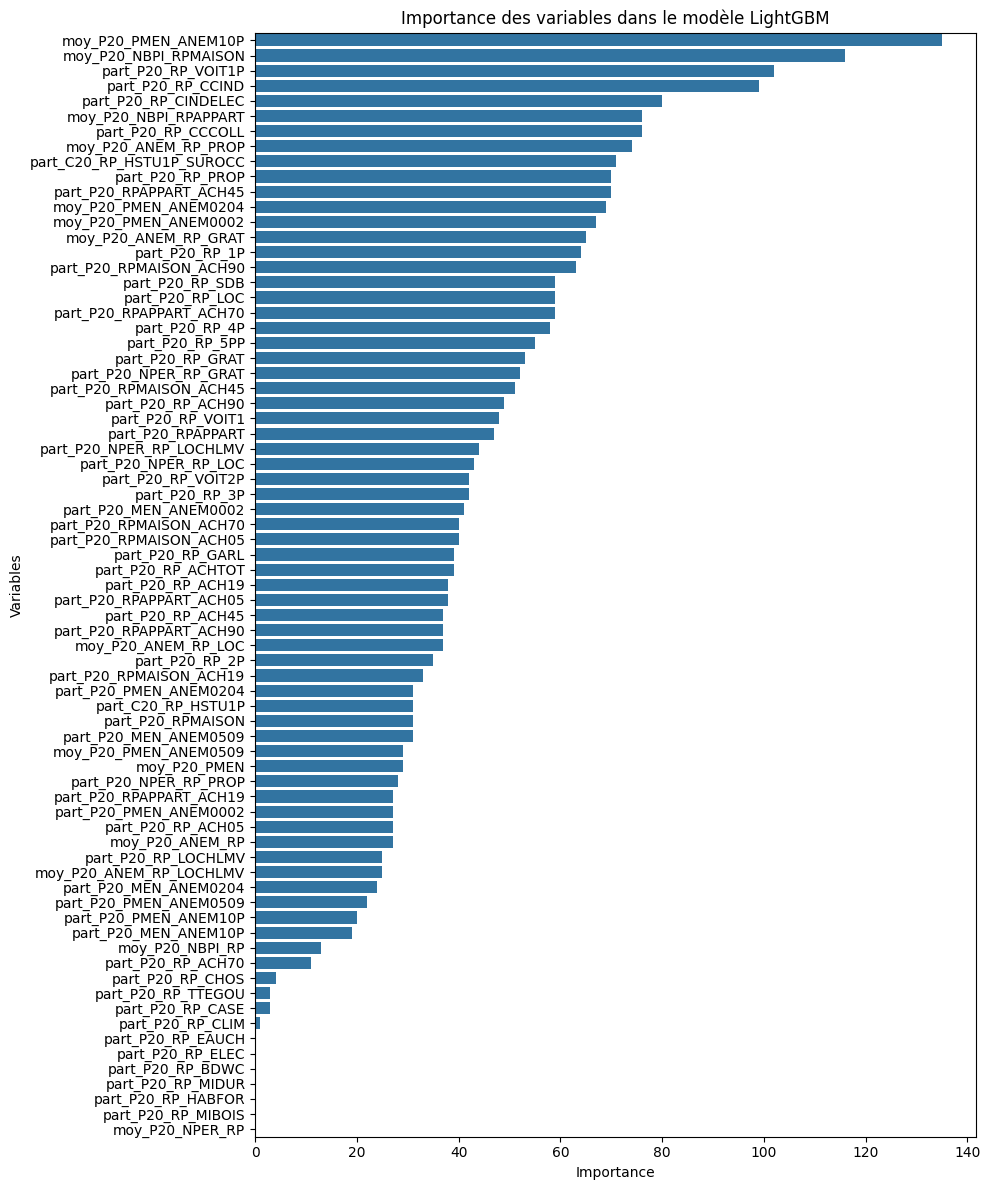

In [ ]:
# 1. Entraîner le modèle sur l'ensemble des données standardisées
lgb_model.fit(X_scaled, y)

# 2. Extraire l'importance des variables
importances = lgb_model.feature_importances_
feature_names = selected_variables

# Créer un DataFrame pour l'importance des variables
feature_importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
})

# Trier les variables par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Visualiser l'importance des variables
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Variable', data=feature_importance_df)
plt.title('Importance des variables dans le modèle LightGBM')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.preprocessing import StandardScaler
import joblib  # Importer joblib pour sauvegarder le scaler

# 1.1. Chargement des données
data = pd.read_csv('housing_commune_with_new_vars.csv', dtype={'DEPCOM': str})

# 1.2. Liste des variables sélectionnées
selected_variables = [
    'moy_P20_NBPI_RPMAISON',
    'part_P20_RP_ACH45',
    'part_P20_RPMAISON_ACH90',
    'part_P20_RP_GARL',
    'part_P20_RP_ACH90',
    'part_P20_RP_4P',
    'part_P20_RPAPPART_ACH45',
    'part_P20_RP_VOIT1P',
    'part_P20_RP_VOIT2P',
    'part_P20_RPMAISON_ACH45',
    'moy_P20_ANEM_RP_LOC',
    'moy_P20_ANEM_RP_PROP',
    'part_P20_NPER_RP_PROP',
    'part_P20_NPER_RP_LOC',
    'part_P20_RP_PROP',
    'part_P20_RP_LOC',
    'part_P20_RP_ACH05',
    'part_P20_RPAPPART_ACH70',
    'part_P20_RP_ACH70',
    'part_P20_RP_ACH19',
    'part_P20_RPMAISON_ACH70',
    'part_P20_RP_LOCHLMV',
    'part_P20_RPMAISON_ACH05',
    'part_P20_NPER_RP_LOCHLMV',
    'moy_P20_ANEM_RP_GRAT',
    'part_P20_RPMAISON_ACH19',
    'moy_P20_NBPI_RPAPPART',
    'part_P20_RP_3P',
    'part_P20_RPAPPART_ACH05',
    'part_P20_RP_VOIT1',
    'part_P20_RPAPPART_ACH19',
    'part_P20_RP_5PP',
    'moy_P20_ANEM_RP_LOCHLMV',
    'part_P20_RP_ACHTOT',
    'moy_P20_PMEN_ANEM0509',
    'part_P20_RP_1P',
    'moy_P20_PMEN_ANEM0204',
    'part_C20_RP_HSTU1P',
    'moy_P20_ANEM_RP',
    'part_P20_RP_GRAT',
    'part_P20_RPAPPART',
    'part_P20_RPMAISON',
    'moy_P20_NBPI_RP',
    'part_P20_PMEN_ANEM0204',
    'part_P20_NPER_RP_GRAT',
    'moy_P20_PMEN_ANEM0002',
    'part_P20_RP_2P',
    'moy_P20_PMEN',
    'moy_P20_NPER_RP',
    'part_P20_MEN_ANEM0204',
    'part_C20_RP_HSTU1P_SUROCC',
    'part_P20_PMEN_ANEM10P',
    'part_P20_PMEN_ANEM0509',
    'part_P20_RPAPPART_ACH90',
    'moy_P20_PMEN_ANEM10P',
    'part_P20_PMEN_ANEM0002',
    'part_P20_MEN_ANEM10P',
    'part_P20_MEN_ANEM0002',
    'part_P20_MEN_ANEM0509'
]

# 1.3. Vérification des variables disponibles
available_columns = data.columns.tolist()
selected_variables = [var for var in selected_variables if var in available_columns]

print("Variables utilisées :")
print(selected_variables)

# 1.4. Préparation des données
data.dropna(subset=selected_variables + ['prop_75_plus_1590'], inplace=True)

# 1.5. Séparation des variables explicatives et de la cible
X = data[selected_variables]
y = data['prop_75_plus_1590']

# 1.6. Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Sauvegarder le scaler**
joblib.dump(scaler, 'scaler.pkl')

# 1.7. Préparer les données pour LightGBM
lgb_data = lgb.Dataset(X_scaled, label=y)

# 1.8. Définir les paramètres
params = {
    'objective': 'regression',
    'learning_rate': 0.1,
    'max_depth': 10,
    'metric': 'rmse',
    'verbose': -1,
    'random_state': 42
}

# 1.9. Définir le callback pour l'arrêt anticipé
callbacks = [early_stopping(stopping_rounds=50, verbose=False)]

# 1.10. Validation croisée avec le callback
cv_results = lgb.cv(
    params,
    lgb_data,
    num_boost_round=1000,
    nfold=5,
    metrics='rmse',
    stratified=False,
    shuffle=True,
    seed=42,
    callbacks=callbacks
)

# 1.11. Nombre optimal d'itérations
best_num_boost_round = len(cv_results['valid rmse-mean'])
print(f"Nombre optimal d'itérations (nombre d'arbres) : {best_num_boost_round}")

# 1.12. RMSE moyen
best_rmse = cv_results['valid rmse-mean'][-1]
print(f"RMSE moyen de la validation croisée : {best_rmse:.4f}")

# 1.13. Entraîner le modèle final sur toutes les données
final_model = lgb.LGBMRegressor(
    n_estimators=best_num_boost_round,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

final_model.fit(X_scaled, y)

# 1.14. Sauvegarder le modèle
final_model.booster_.save_model('lightgbm_model.txt')


Variables utilisées :
['moy_P20_NBPI_RPMAISON', 'part_P20_RP_ACH45', 'part_P20_RPMAISON_ACH90', 'part_P20_RP_GARL', 'part_P20_RP_ACH90', 'part_P20_RP_4P', 'part_P20_RPAPPART_ACH45', 'part_P20_RP_VOIT1P', 'part_P20_RP_VOIT2P', 'part_P20_RPMAISON_ACH45', 'moy_P20_ANEM_RP_LOC', 'moy_P20_ANEM_RP_PROP', 'part_P20_NPER_RP_PROP', 'part_P20_NPER_RP_LOC', 'part_P20_RP_PROP', 'part_P20_RP_LOC', 'part_P20_RP_ACH05', 'part_P20_RPAPPART_ACH70', 'part_P20_RP_ACH70', 'part_P20_RP_ACH19', 'part_P20_RPMAISON_ACH70', 'part_P20_RP_LOCHLMV', 'part_P20_RPMAISON_ACH05', 'part_P20_NPER_RP_LOCHLMV', 'moy_P20_ANEM_RP_GRAT', 'part_P20_RPMAISON_ACH19', 'moy_P20_NBPI_RPAPPART', 'part_P20_RP_3P', 'part_P20_RPAPPART_ACH05', 'part_P20_RP_VOIT1', 'part_P20_RPAPPART_ACH19', 'part_P20_RP_5PP', 'moy_P20_ANEM_RP_LOCHLMV', 'part_P20_RP_ACHTOT', 'moy_P20_PMEN_ANEM0509', 'part_P20_RP_1P', 'moy_P20_PMEN_ANEM0204', 'part_C20_RP_HSTU1P', 'moy_P20_ANEM_RP', 'part_P20_RP_GRAT', 'part_P20_RPAPPART', 'part_P20_RPMAISON', 'moy_P20_

#Prédiction à l'IRIS

Dans cette dernière étape, on collecte les données à l'iris (les mêmes variables celles de l'entrainement sont utilisées ici) et on applique le modèle de régression peécédemment entrainé.


**Objectif: obtenir des prédictions précises à l'IRIS, des proportions de séniors de 75 ans ou plus dépassant le seuil de salaire de 1570 euros.**

In [ ]:
# Code pour charger le modèle entraîné et prédire la proportion de séniors au-dessus de 1590 euros pour chaque IRIS

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import joblib

# ----------------------------------------------------
# Étape 1 : Charger le modèle
# ----------------------------------------------------

# 1.1. Charger le modèle LightGBM sauvegardé
model = lgb.Booster(model_file='lightgbm_model.txt')



# ----------------------------------------------------
# Étape 2 : Préparation des données IRIS pour la prédiction
# ----------------------------------------------------

# 2.1. Charger les données de logement au niveau IRIS
iris_data = pd.read_csv('base-ic-logement-2020.CSV', sep=';', dtype={'IRIS': str, 'COM': str})

# 2.2. Liste des variables initiales (variables problématiques supprimées)
variables = [
    'P20_RP',
    'P20_RP_1P',
    'P20_RP_2P',
    'P20_RP_3P',
    'P20_RP_4P',
    'P20_RP_5PP',
    'P20_NBPI_RP',
    'P20_RPMAISON',
    'P20_NBPI_RPMAISON',
    'P20_RPAPPART',
    'P20_NBPI_RPAPPART',
    'P20_RP_ACHTOT',
    'P20_RP_ACH19',
    'P20_RP_ACH45',
    'P20_RP_ACH70',
    'P20_RP_ACH90',
    'P20_RP_ACH05',
    'P20_RPMAISON_ACH19',
    'P20_RPMAISON_ACH45',
    'P20_RPMAISON_ACH70',
    'P20_RPMAISON_ACH90',
    'P20_RPMAISON_ACH05',
    'P20_RPAPPART_ACH19',
    'P20_RPAPPART_ACH45',
    'P20_RPAPPART_ACH70',
    'P20_RPAPPART_ACH90',
    'P20_RPAPPART_ACH05',
    'P20_NBPI_RP_ANEM0002',
    'P20_NBPI_RP_ANEM0204',
    'P20_NBPI_RP_ANEM0509',
    'P20_NBPI_RP_ANEM10P',
    'P20_RP_PROP',
    'P20_RP_LOC',
    'P20_RP_LOCHLMV',
    'P20_RP_GRAT',
    'P20_NPER_RP',
    'P20_NPER_RP_PROP',
    'P20_NPER_RP_LOC',
    'P20_NPER_RP_LOCHLMV',
    'P20_NPER_RP_GRAT',
    'P20_ANEM_RP',
    'P20_ANEM_RP_PROP',
    'P20_ANEM_RP_LOC',
    'P20_ANEM_RP_LOCHLMV',
    'P20_ANEM_RP_GRAT',
    'C20_RP_HSTU1P',
    'C20_RP_HSTU1P_SUROCC',
    # Variables des ménages
    'P20_RP_GARL',
    'P20_RP_VOIT1P',
    'P20_RP_VOIT1',
    'P20_RP_VOIT2P',
    'P20_MEN',
    'P20_MEN_ANEM0002',
    'P20_MEN_ANEM0204',
    'P20_MEN_ANEM0509',
    'P20_MEN_ANEM10P',
    'P20_MEN_ANEM1019',
    'P20_MEN_ANEM2029',
    'P20_MEN_ANEM30P',
    'P20_PMEN',
    'P20_PMEN_ANEM0002',
    'P20_PMEN_ANEM0204',
    'P20_PMEN_ANEM0509',
    'P20_PMEN_ANEM10P'
]

# 2.3. Vérification des variables disponibles
available_columns = iris_data.columns.tolist()
variables = [var for var in variables if var in available_columns]

print("Variables utilisées pour la préparation des données IRIS :")
print(variables)

# 2.4. Conversion des variables en numériques
for col in variables:
    iris_data[col] = pd.to_numeric(iris_data[col], errors='coerce')

# 2.5. Supprimer les lignes avec des valeurs manquantes dans les variables initiales
iris_data.dropna(subset=variables, inplace=True)

# 2.6. Création des variables de proportion et de moyenne

# Dictionnaire des variables et leurs dénominateurs pour la transformation en proportion
variables_proportion = {}

# Variables à diviser par P20_RP
variables_P20_RP = [
    'P20_RP_1P', 'P20_RP_2P', 'P20_RP_3P', 'P20_RP_4P', 'P20_RP_5PP',
    'P20_RPMAISON', 'P20_RPAPPART',
    'P20_RP_PROP', 'P20_RP_LOC', 'P20_RP_LOCHLMV', 'P20_RP_GRAT',
    'P20_RP_ACHTOT', 'P20_RP_ACH19', 'P20_RP_ACH45', 'P20_RP_ACH70', 'P20_RP_ACH90',
    'P20_RP_ACH05',
    'C20_RP_HSTU1P', 'C20_RP_HSTU1P_SUROCC'
    # Les variables problématiques ont été retirées
]

# Filtrer les variables disponibles
variables_P20_RP = [var for var in variables_P20_RP if var in available_columns]

for var in variables_P20_RP:
    variables_proportion[var] = 'P20_RP'

# Variables à diviser par P20_RPMAISON
variables_P20_RPMAISON = [
    'P20_RPMAISON_ACH19', 'P20_RPMAISON_ACH45', 'P20_RPMAISON_ACH70',
    'P20_RPMAISON_ACH90', 'P20_RPMAISON_ACH05'
]

variables_P20_RPMAISON = [var for var in variables_P20_RPMAISON if var in available_columns]

for var in variables_P20_RPMAISON:
    variables_proportion[var] = 'P20_RPMAISON'

# Variables à diviser par P20_RPAPPART
variables_P20_RPAPPART = [
    'P20_RPAPPART_ACH19', 'P20_RPAPPART_ACH45', 'P20_RPAPPART_ACH70',
    'P20_RPAPPART_ACH90', 'P20_RPAPPART_ACH05'
]

variables_P20_RPAPPART = [var for var in variables_P20_RPAPPART if var in available_columns]

for var in variables_P20_RPAPPART:
    variables_proportion[var] = 'P20_RPAPPART'

# Variables à diviser par P20_NPER_RP
variables_NPER = [
    'P20_NPER_RP_PROP', 'P20_NPER_RP_LOC', 'P20_NPER_RP_LOCHLMV', 'P20_NPER_RP_GRAT'
]

variables_NPER = [var for var in variables_NPER if var in available_columns]

for var in variables_NPER:
    variables_proportion[var] = 'P20_NPER_RP'

# Variables à diviser par P20_MEN
variables_P20_MEN = [
    'P20_RP_GARL',
    'P20_RP_VOIT1P',
    'P20_RP_VOIT1',
    'P20_RP_VOIT2P',
    'P20_MEN_ANEM0002',
    'P20_MEN_ANEM0204',
    'P20_MEN_ANEM0509',
    'P20_MEN_ANEM10P',
    'P20_MEN_ANEM1019',
    'P20_MEN_ANEM2029',
    'P20_MEN_ANEM30P'
]

variables_P20_MEN = [var for var in variables_P20_MEN if var in available_columns]

for var in variables_P20_MEN:
    variables_proportion[var] = 'P20_MEN'

# Variables à diviser par P20_PMEN
variables_P20_PMEN = [
    'P20_PMEN_ANEM0002',
    'P20_PMEN_ANEM0204',
    'P20_PMEN_ANEM0509',
    'P20_PMEN_ANEM10P'
]

variables_P20_PMEN = [var for var in variables_P20_PMEN if var in available_columns]

for var in variables_P20_PMEN:
    variables_proportion[var] = 'P20_PMEN'

# Dictionnaire des variables pour le calcul de moyennes
variables_average = {
    'P20_NBPI_RP': 'P20_RP',
    'P20_NBPI_RPMAISON': 'P20_RPMAISON',
    'P20_NBPI_RPAPPART': 'P20_RPAPPART',
    'P20_NPER_RP': 'P20_RP',
    'P20_ANEM_RP': 'P20_RP',
    'P20_ANEM_RP_PROP': 'P20_RP_PROP',
    'P20_ANEM_RP_LOC': 'P20_RP_LOC',
    'P20_ANEM_RP_LOCHLMV': 'P20_RP_LOCHLMV',
    'P20_ANEM_RP_GRAT': 'P20_RP_GRAT',
    'P20_PMEN': 'P20_MEN',
    'P20_PMEN_ANEM0002': 'P20_MEN_ANEM0002',
    'P20_PMEN_ANEM0204': 'P20_MEN_ANEM0204',
    'P20_PMEN_ANEM0509': 'P20_MEN_ANEM0509',
    'P20_PMEN_ANEM10P': 'P20_MEN_ANEM10P'
}

# Filtrer les variables disponibles pour les moyennes
variables_average = {k: v for k, v in variables_average.items() if k in available_columns and v in available_columns}

# Calcul des variables de proportion en gérant les zéros dans les dénominateurs
for var, denom in variables_proportion.items():
    # Éviter la division par zéro en remplaçant les dénominateurs nuls par 1
    # ou en utilisant np.where pour mettre le résultat à zéro lorsque le dénominateur est nul
    iris_data['part_' + var] = np.where(
        iris_data[denom] == 0,
        0,
        iris_data[var] / iris_data[denom]
    )

# Calcul des variables moyennes en gérant les zéros dans les dénominateurs
for var, denom in variables_average.items():
    iris_data['moy_' + var] = np.where(
        iris_data[denom] == 0,
        0,
        iris_data[var] / iris_data[denom]
    )

# Mise à jour de la liste des nouvelles variables créées
new_variables = ['part_' + var for var in variables_proportion.keys()] + ['moy_' + var for var in variables_average.keys()]

# **Option 1 :** Ne pas supprimer les lignes avec des valeurs manquantes dans les nouvelles variables
# **Option 2 :** Remplacer les NaN résultant de divisions par zéro par zéro
# Nous avons déjà géré les divisions par zéro, donc il ne devrait pas y avoir de NaN
# Par précaution, nous pouvons remplir les NaN avec zéro
iris_data[new_variables] = iris_data[new_variables].fillna(0)

# 2.7. Préparation des données pour la prédiction

# Variables sélectionnées dans le modèle (variables problématiques retirées)
selected_variables = [
    'moy_P20_NBPI_RPMAISON',
    'part_P20_RP_ACH45',
    'part_P20_RPMAISON_ACH90',
    'part_P20_RP_GARL',
    'part_P20_RP_ACH90',
    'part_P20_RP_4P',
    'part_P20_RPAPPART_ACH45',
    'part_P20_RP_VOIT1P',
    'part_P20_RP_VOIT2P',
    'part_P20_RPMAISON_ACH45',
    'moy_P20_ANEM_RP_LOC',
    'moy_P20_ANEM_RP_PROP',
    'part_P20_NPER_RP_PROP',
    'part_P20_NPER_RP_LOC',
    'part_P20_RP_PROP',
    'part_P20_RP_LOC',
    'part_P20_RP_ACH05',
    'part_P20_RPAPPART_ACH70',
    'part_P20_RP_ACH70',
    'part_P20_RP_ACH19',
    'part_P20_RPMAISON_ACH70',
    'part_P20_RP_LOCHLMV',
    'part_P20_RPMAISON_ACH05',
    'part_P20_NPER_RP_LOCHLMV',
    'moy_P20_ANEM_RP_GRAT',
    'part_P20_RPMAISON_ACH19',
    'moy_P20_NBPI_RPAPPART',
    'part_P20_RP_3P',
    'part_P20_RPAPPART_ACH05',
    'part_P20_RP_VOIT1',
    'part_P20_RPAPPART_ACH19',
    'part_P20_RP_5PP',
    'moy_P20_ANEM_RP_LOCHLMV',
    'part_P20_RP_ACHTOT',
    'moy_P20_PMEN_ANEM0509',
    'part_P20_RP_1P',
    'moy_P20_PMEN_ANEM0204',
    'part_C20_RP_HSTU1P',
    'moy_P20_ANEM_RP',
    'part_P20_RP_GRAT',
    'part_P20_RPAPPART',
    'part_P20_RPMAISON',
    'moy_P20_NBPI_RP',
    'part_P20_PMEN_ANEM0204',
    'part_P20_NPER_RP_GRAT',
    'moy_P20_PMEN_ANEM0002',
    'part_P20_RP_2P',
    'moy_P20_PMEN',
    'moy_P20_NPER_RP',
    'part_P20_MEN_ANEM0204',
    'part_C20_RP_HSTU1P_SUROCC',
    'part_P20_PMEN_ANEM10P',
    'part_P20_PMEN_ANEM0509',
    'part_P20_RPAPPART_ACH90',
    'moy_P20_PMEN_ANEM10P',
    'part_P20_PMEN_ANEM0002',
    'part_P20_MEN_ANEM10P',
    'part_P20_MEN_ANEM0002',
    'part_P20_MEN_ANEM0509'
]

# Vérifier que les variables sélectionnées sont présentes
available_columns = iris_data.columns.tolist()
selected_variables = [var for var in selected_variables if var in available_columns]

print("Variables utilisées pour la prédiction :")
print(selected_variables)

# Extraire les variables pour la prédiction
X_new = iris_data[selected_variables]
print(f"Taille de X_new : {X_new.shape}")

# 2.8. Standardiser les nouvelles données
scaler_iris = StandardScaler()
X_new_scaled = scaler_iris.fit_transform(X_new)

# 2.9. Prédire les valeurs avec le modèle entraîné
y_pred = model.predict(X_new_scaled)

# 2.10. Ajouter les prédictions au DataFrame
iris_data['prop_75_plus_1590_pred'] = y_pred

# 2.11. Sauvegarde des prédictions

# Colonnes d'identification et prédictions
columns_to_save = ['IRIS', 'COM', 'prop_75_plus_1590_pred']

# Créer un DataFrame avec les colonnes à sauvegarder
predictions = iris_data[columns_to_save]

# Sauvegarder dans un fichier CSV
predictions.to_csv('predictions_prop_75_plus_1590_IRIS.csv', index=False)

print("Les prédictions ont été sauvegardées dans 'predictions_prop_75_plus_1590_IRIS.csv'.")


<ipython-input-86-69608e277043>:24: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  iris_data = pd.read_csv('base-ic-logement-2020.CSV', sep=';', dtype={'IRIS': str, 'COM': str})


Variables utilisées pour la préparation des données IRIS :
['P20_RP', 'P20_RP_1P', 'P20_RP_2P', 'P20_RP_3P', 'P20_RP_4P', 'P20_RP_5PP', 'P20_NBPI_RP', 'P20_RPMAISON', 'P20_NBPI_RPMAISON', 'P20_RPAPPART', 'P20_NBPI_RPAPPART', 'P20_RP_ACHTOT', 'P20_RP_ACH19', 'P20_RP_ACH45', 'P20_RP_ACH70', 'P20_RP_ACH90', 'P20_RP_ACH05', 'P20_RPMAISON_ACH19', 'P20_RPMAISON_ACH45', 'P20_RPMAISON_ACH70', 'P20_RPMAISON_ACH90', 'P20_RPMAISON_ACH05', 'P20_RPAPPART_ACH19', 'P20_RPAPPART_ACH45', 'P20_RPAPPART_ACH70', 'P20_RPAPPART_ACH90', 'P20_RPAPPART_ACH05', 'P20_NBPI_RP_ANEM0002', 'P20_NBPI_RP_ANEM0204', 'P20_NBPI_RP_ANEM0509', 'P20_NBPI_RP_ANEM10P', 'P20_RP_PROP', 'P20_RP_LOC', 'P20_RP_LOCHLMV', 'P20_RP_GRAT', 'P20_NPER_RP', 'P20_NPER_RP_PROP', 'P20_NPER_RP_LOC', 'P20_NPER_RP_LOCHLMV', 'P20_NPER_RP_GRAT', 'P20_ANEM_RP', 'P20_ANEM_RP_PROP', 'P20_ANEM_RP_LOC', 'P20_ANEM_RP_LOCHLMV', 'P20_ANEM_RP_GRAT', 'C20_RP_HSTU1P', 'C20_RP_HSTU1P_SUROCC', 'P20_RP_GARL', 'P20_RP_VOIT1P', 'P20_RP_VOIT1', 'P20_RP_VOIT2P', '

#Performances du modèle

**Erreur moyenne :** Le modèle présente une erreur moyenne de 0,05, ce qui signifie que les prédictions s'écartent en moyenne de 5% des valeurs réelles.

**Interprétation :** Étant donné que les proportions à prédire sont généralement élevées, l'erreur relative est considérée comme faible et acceptable pour de nombreuses applications pratiques.

**Note:** Les performances du modèle s'améliorent à mesure que le seuil de revenu fixé augmente, indiquant une meilleure précision pour prédire les niveaux de revenus plus élevés.